# This notebook creates functions for dreaming and diplays sample dream results with different networks. 

__The code will run on the cpu. cuda compatibility not added to the functions__

In [29]:
import os
import random
import math
import scipy
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
from torch.nn import functional as F

from library.dict_network import dict_net

In [30]:
def create_random_image(image_dim,img_is2D,random_seed=0):
    '''Creates a random image of of shape given by image_dim which should be a tuple of length 3 HxWxC '''
    np.random.seed(random_seed)
    rand_image_np = np.random.random(image_dim)*255
    
    if img_is2D:
        rand_image = Image.fromarray((rand_image_np)[:,:,0].astype('uint8'),'L')
    else:
        rand_image = Image.fromarray((rand_image_np).astype('uint8'),'RGB')

    return rand_image

In [31]:
def preprocess_image(input_image,mean,std):
    '''Converts a PIL image to tensor and normalizes according to the mean and std provided,
    both of which should be tuples of length 3'''
    preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

    return preprocess(input_image)

In [32]:
class GaussianFilter:
    '''Creates a gaussian filter with given kernel size and sigma values.
    This filter is used to apply gaussian filter on an input image(2D or 3D
    depending on the variable input_img_is2D) through convolution'''
    def __init__(self,input_img_is2D=True,kernel_size=3,sigma=0.5):
        
        x_cord = torch.arange(kernel_size)
        x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1)
        xy_grid = xy_grid.float()

        mean = (kernel_size - 1)/2.
        variance = sigma**2.
        gaussian_kernel = (1./(2.*math.pi*variance)) * torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1) /(2*variance))
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
        
        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        pad = math.floor(kernel_size/2)
        
        if input_img_is2D:
            self.gaussian_filter = nn.Conv2d(in_channels=1,out_channels=1,padding=pad,kernel_size=kernel_size, groups=1,bias=False)
            
        else: # input image is 3D
            gaussian_kernel = gaussian_kernel.repeat(3, 1, 1, 1)
            self.gaussian_filter = nn.Conv2d(in_channels=3,out_channels=3,padding=pad,kernel_size=kernel_size, groups=3,bias=False)
            
        self.gaussian_filter.weight.data = gaussian_kernel
        self.gaussian_filter.weight.requires_grad = False   
        
    def __call__(self,input_tensor):
        return self.gaussian_filter(input_tensor)

In [33]:
def postprocess_batch(image_tensor,mean,std,img_is2D):
    '''Multiplies and then adds channelwise the tensor with the std and mean tuples respectively. In short, does the 
    inverse of the normalizing function in preprocess'''
    #image_dim = image_tensor.shape
        
    if img_is2D:
        image_tensor = image_tensor*std[0] + mean[0]
    else:
        image_tensor = image_tensor * torch.Tensor(list(std)).view(1,3,1,1) + torch.Tensor(list(mean)).view(1,3,1,1)
        
    return image_tensor

In [34]:
def batch_dream(network,labels,image_dim,mean,std,nItr=100,lr=0.1,
                kernel_size=3,sigma=0.5,normalization=True,clamping=True,gaussian=True):
    '''Given a trained convolutional network and an output label number,
    function returns an image that has been optimized to output high confidence
    for that label when forward passed through the network
    image_dim : tuple with length 2 or 3 for 2D or 3D image to be produced. HxWxC Example (224,224,3) or (32,128,1)
    mean : tuple of length 3 with mean pixel value. Example (0.5,0.5,0.5) for 3D, (0.5,) for 2D
    mean : tuple of length 3 with standard deviation of pixel values. Example (0.5,0.5,0.5) for 3D, (0.5,) for 2D
    '''
    network.eval()
    img_is2D = check_if2D(image_dim)
    
    gaussian_filter = GaussianFilter(img_is2D,kernel_size,sigma)
    
    for i in range(len(labels)):
        im = create_random_image(image_dim,img_is2D)
        im = preprocess_image(im,mean,std)
        if i== 0:
            img = im.unsqueeze(0)
        else:
            img = torch.cat((img,im.unsqueeze(0)),0)
    
    img = Variable(img,requires_grad=True)
    
    for _ in range(nItr):
        out = network(img)
        
        loss = 0
        for index,label in enumerate(labels):
            loss += out[index,label]
        
        loss.backward()
        
        if normalization:
            avg_grad = np.abs(img.grad.data.cpu().numpy()).mean()
            norm_lr = lr / (avg_grad + 1e-20)
        else:
            norm_lr = lr
        img.data += norm_lr * img.grad.data
        
        if clamping:
            img.data = torch.clamp(img.data,-1,1)
        
        if gaussian:
            img.data = gaussian_filter(img.data)

        img.grad.data.zero_()
    img = postprocess_batch(img,mean,std,img_is2D)
    
    
    return img

In [35]:
def check_if2D(image_dim):
    '''Given a image shape returns a bool whether the image is 2D or 3D. Input tuple should be of the form HxWxC'''
    if image_dim[-1] == 1:
        img_is2D = True
    elif image_dim[-1] == 3:
        img_is2D = False
    else:
        print("image dimension not correct")
        return
    return img_is2D

In [36]:
def display_grid(batch_tensor):
    '''Displays a tensor (batch of images) in grid form. Tensor should be of shape BxCxHxW'''
    batch_tensor = batch_tensor.detach()
    grid_img = utils.make_grid(batch_tensor, nrow=4)
    plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(grid_img.permute(1, 2, 0))

In [37]:
def save_image(batch_tensor):
    '''Saves a tensor (batch of images) in grid form. Tensor should be of shape BxCxHxW'''
    batch_tensor = batch_tensor.detach()
    utils.save_image(batch_tensor,"dreams.png",nrow=4)

## Create dream images with a DictNet trained on mjsynth dataset

In [38]:
network = dict_net.DictNet(1000)

In [39]:
network.load_state_dict(torch.load("models/net_1000_0.001_200_0.0.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [40]:
output_batch = batch_dream(network,[0,1,2,3],(32,128,1),(0.47,),(0.14,))

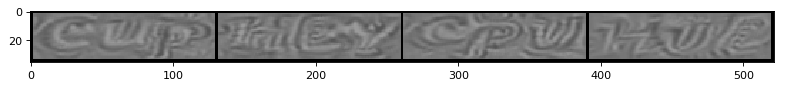

In [41]:
display_grid(output_batch)

### Create the same dreams, only this time without learning rate normalization during optimization

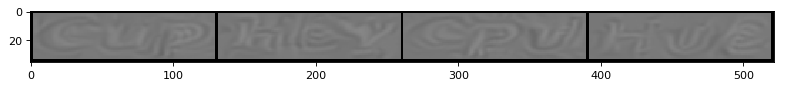

In [42]:
output_batch_0 = batch_dream(network,[0,1,2,3],(32,128,1),(0.47,),(0.14,),normalization=False)
display_grid(output_batch_0)

### Create the same dreams, only this time without clamping the tensor between -1 and 1 during optimization

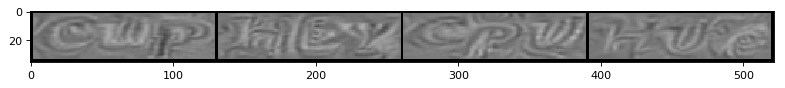

In [43]:
output_batch_1 = batch_dream(network,[0,1,2,3],(32,128,1),(0.47,),(0.14,),clamping=False)
display_grid(output_batch_1)

### Create the same dreams, only this time without gaussian filter smoothing out the image during optimization

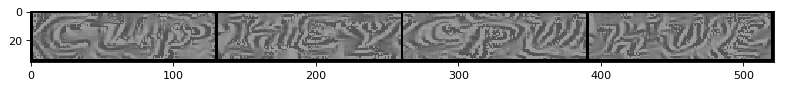

In [44]:
output_batch_2 = batch_dream(network,[0,1,2,3],(32,128,1),(0.47,),(0.14,),gaussian=False)
display_grid(output_batch_2)

## Create dreams with a network (https://nextjournal.com/gkoehler/pytorch-mnist) trained on MNIST

In [45]:
from deep_dream_mnist import network_mnist

In [46]:
network = network_mnist.Net()

In [47]:
network.load_state_dict(torch.load('deep_dream_mnist/mnist.pth'))

<All keys matched successfully>

In [48]:
output_batch = batch_dream(network,[0,4,2,8],(28,28,1),(0.13,),(0.31,))

/mnt/c/Users/User/Desktop/activation_maximization_mjsynth/deep_dream_mnist/network_mnist.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


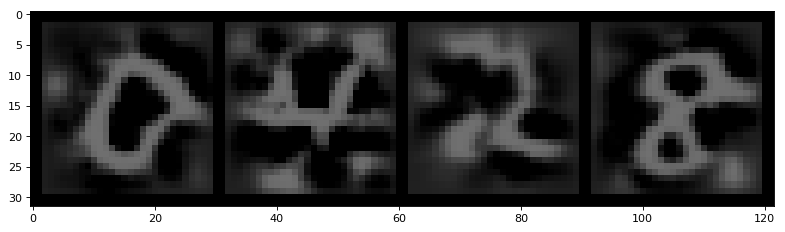

In [49]:
display_grid(output_batch)

## Create dreams with a VGG19 network trained on ImageNet

In [50]:
network = models.vgg19(pretrained=True)

In [51]:
output_batch = batch_dream(network,[79,130,736,883],(224,224,3),(0.485, 0.456, 0.406),(0.229, 0.224, 0.225),nItr=400) 

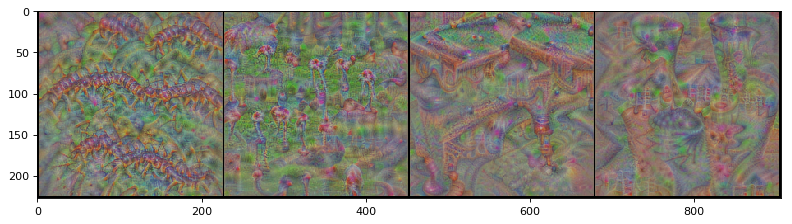

In [52]:
display_grid(output_batch)